# 一、前期工作

本文将手把手教你用TensorFlow2实现验证的识别，整个项目的完整代码都在文章了哈，大家按顺序copy即可运行。

🔥本文 GitHub [https://github.com/kzbkzb/Python-AI](https://github.com/kzbkzb/Python-AI) 已收录

- 作者：[K同学啊](https://mp.weixin.qq.com/s/NES9RhtAhbX_jsmGua28dA)
- 来自专栏：《深度学习100例》-Tensorflow2版本
- 数据链接：https://pan.baidu.com/s/1seo9uOykQwAcsV7_Wqw7gQ （提取码：vw70）

我的环境：

- 语言环境：Python3.6.5
- 编译器：jupyter notebook
- 深度学习环境：TensorFlow2.4.1

## 1.设置GPU

如果使用的是CPU可以注释掉这部分的代码，不影响运行。

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)  #设置GPU显存用量按需使用
    tf.config.set_visible_devices([gpus[0]],"GPU")

## 2.导入数据

In [2]:
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

import os,PIL,random,pathlib

# 设置随机种子尽可能使结果可以重现
import numpy as np
np.random.seed(1)

# 设置随机种子尽可能使结果可以重现
import tensorflow as tf
tf.random.set_seed(1)

In [3]:
data_dir = "D:/jupyter notebook/DL-100-days/datasets/captcha"
data_dir = pathlib.Path(data_dir)

all_image_paths = list(data_dir.glob('*'))
all_image_paths = [str(path) for path in all_image_paths]

# 打乱数据
random.shuffle(all_image_paths)

# 获取数据标签
all_label_names = [path.split("\\")[5].split(".")[0] for path in all_image_paths]

image_count = len(all_image_paths)
print("图片总数为：",image_count)

图片总数为： 1070


## 3.数据可视化

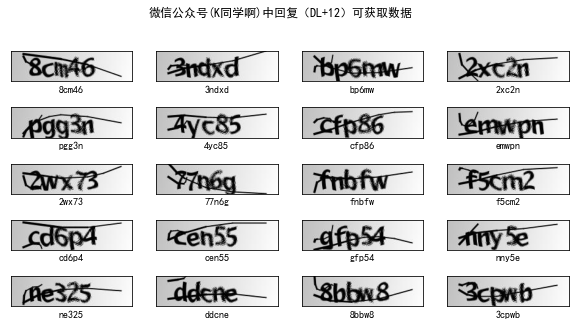

In [4]:
plt.figure(figsize=(10,5))
plt.suptitle("微信公众号(K同学啊)中回复（DL+12）可获取数据")

for i in range(20):
    plt.subplot(5,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # 显示图片
    images = plt.imread(all_image_paths[i])
    plt.imshow(images)
    # 显示标签
    plt.xlabel(all_label_names[i])

plt.show()

## 4.标签数字化

In [5]:
number   = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
char_set       = number + alphabet
char_set_len   = len(char_set)
label_name_len = len(all_label_names[0])


# 将字符串数字化
def text2vec(text):
    vector = np.zeros([label_name_len, char_set_len])
    for i, c in enumerate(text):
        idx = char_set.index(c)
        vector[i][idx] = 1.0
    return vector

all_labels = [text2vec(i) for i in all_label_names]

# 二、构建一个tf.data.Dataset

## 1.预处理函数

In [6]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, [50, 200])
    return image/255.0

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

## 2.加载数据

构建 `tf.data.Dataset` 最简单的方法就是使用 `from_tensor_slices` 方法。

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

path_ds  = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(all_labels)

image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
image_label_ds

<ZipDataset shapes: ((50, 200, 1), (5, 36)), types: (tf.float32, tf.float64)>

In [8]:
train_ds = image_label_ds.take(1000)  # 前1000个batch
val_ds   = image_label_ds.skip(1000)  # 跳过前1000，选取后面的

## 3.配置数据

先复习一下`prefetch()`函数。`prefetch()`功能详细介绍：CPU 正在准备数据时，加速器处于空闲状态。相反，当加速器正在训练模型时，CPU 处于空闲状态。因此，训练所用的时间是 CPU 预处理时间和加速器训练时间的总和。`prefetch()`将训练步骤的预处理和模型执行过程重叠到一起。当加速器正在执行第 N 个训练步时，CPU 正在准备第 N+1 步的数据。这样做不仅可以最大限度地缩短训练的单步用时（而不是总用时），而且可以缩短提取和转换数据所需的时间。如果不使用`prefetch()`，CPU 和 GPU/TPU 在大部分时间都处于空闲状态：

![](pictures/12-1.png)

使用`prefetch()`可显著减少空闲时间：

![image.png](pictures/12-2.png)

In [9]:
BATCH_SIZE = 16

train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
val_ds

<PrefetchDataset shapes: ((None, 50, 200, 1), (None, 5, 36)), types: (tf.float32, tf.float64)>

# 三、搭建网络模型

目前这里主要是带大家跑通代码、整理一下思路，大家可以自行优化网络结构、调整模型参数。后续我也会针对性的出一些调优的案例的。

In [10]:
from tensorflow.keras import datasets, layers, models

model = models.Sequential([
    
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 200, 1)),#卷积层1，卷积核3*3
    layers.MaxPooling2D((2, 2)),                   #池化层1，2*2采样
    layers.Conv2D(64, (3, 3), activation='relu'),  #卷积层2，卷积核3*3
    layers.MaxPooling2D((2, 2)),                   #池化层2，2*2采样
    
    layers.Flatten(),                              #Flatten层，连接卷积层与全连接层
    layers.Dense(1000, activation='relu'),         #全连接层，特征进一步提取
    
    layers.Dense(label_name_len * char_set_len),
    layers.Reshape([label_name_len, char_set_len]),
    layers.Softmax()                               #输出层，输出预期结果
])
# 打印网络结构
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 198, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 48, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 33792)             0         
_________________________________________________________________
dense (Dense)                (None, 1000)              33793000  
_________________________________________________________________
dense_1 (Dense)              (None, 180)               1

# 四、编译

In [11]:
model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 五、训练

In [12]:
epochs = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
63/63 [==============================] - 4s 21ms/step - loss: 3.2998 - accuracy: 0.0934 - val_loss: 2.2876 - val_accuracy: 0.2943
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 1.7016 - accuracy: 0.5195 - val_loss: 1.2014 - val_accuracy: 0.6314
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 0.5267 - accuracy: 0.8379 - val_loss: 0.9039 - val_accuracy: 0.7286
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 0.1911 - accuracy: 0.9442 - val_loss: 0.8609 - val_accuracy: 0.7457
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 0.0916 - accuracy: 0.9714 - val_loss: 0.8937 - val_accuracy: 0.7886
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 0.0680 - accuracy: 0.9798 - val_loss: 0.5842 - val_accuracy: 0.8429
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 0.0443 - accuracy: 0.9900 - val_loss: 0.6235 - val_accuracy: 0.8200
Epoch 8/20
63/

# 六、模型评估

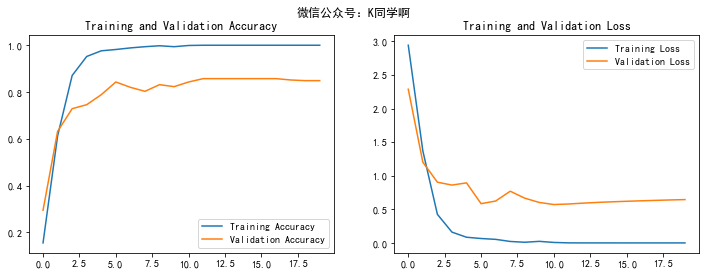

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.suptitle("微信公众号：K同学啊")

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 七、保存和加载模型

In [14]:
# 保存模型
model.save('model/12_model.h5')

In [15]:
# 加载模型
new_model = tf.keras.models.load_model('model/12_model.h5')

# 八、预测

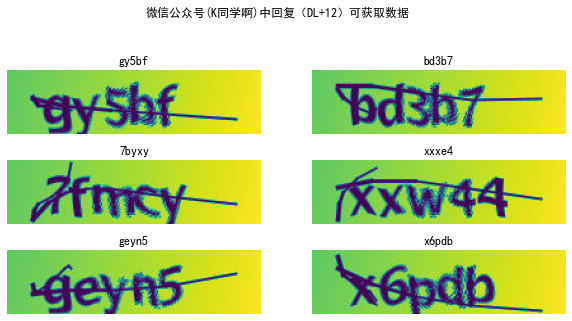

In [16]:
def vec2text(vec):
    """
    还原标签（向量->字符串）
    """
    text = []
    for i, c in enumerate(vec):
        text.append(char_set[c])
    return "".join(text)

plt.figure(figsize=(10, 8))            # 图形的宽为10高为8
plt.suptitle("微信公众号(K同学啊)中回复（DL+12）可获取数据")

for images, labels in val_ds.take(1):
    for i in range(6):
        ax = plt.subplot(5, 2, i + 1)  
        # 显示图片
        plt.imshow(images[i])

        # 需要给图片增加一个维度
        img_array = tf.expand_dims(images[i], 0) 

        # 使用模型预测验证码
        predictions = model.predict(img_array)
        plt.title(vec2text(np.argmax(predictions, axis=2)[0]))

        plt.axis("off")

可以看到验证码中大部分字符预测都是对的，但是少部分字符还是存在问题，大家可以试试优化一下网络结构，调整网络参数等。本案例适合练习优化技巧，借着这个案例了解一下不同的调整对结果有什么不同。

**来自专栏：**[**《深度学习100例》**](https://blog.csdn.net/qq_38251616/category_11068756.html)

往期精彩内容：

- [**深度学习100例-卷积神经网络（VGG-19）识别灵笼中的人物 | 第7天**](https://mtyjkh.blog.csdn.net/article/details/117395797)
- [**深度学习100例 -卷积神经网络（ResNet-50）鸟类识别 | 第8天**](https://mtyjkh.blog.csdn.net/article/details/117587326)
- [**循环神经网络（RNN）实现股票预测-深度学习100例 | 第9天**](https://mtyjkh.blog.csdn.net/article/details/117752046)
- [**循环神经网络（LSTM）实现股票预测-深度学习100例 | 第10天**](https://mtyjkh.blog.csdn.net/article/details/117907074)
- [**卷积神经网络（AlexNet）手把手教学-深度学习100例 | 第11天**](https://mtyjkh.blog.csdn.net/article/details/117986183)

可接外包项目，有需要的可以通过左侧联系方式找到我，备注：CSDN+外包

**关注、点赞、收藏，送我上热搜，谢谢大家啦！**